# IBM HR Attrition Mini Project  
_A 2‑hour, end‑to‑end people‑analytics walkthrough_

**Pipeline:** Load → Clean → EDA → K‑Means personas → PCA visual → Logistic‑regression baseline  
**Key question:** _“Who is most likely to leave, and why?”_

In [1]:
pip install kagglehub pandas numpy matplotlib seaborn scikit-learn


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("pavansubhasht/ibm-hr-analytics-attrition-dataset")

print("Path to dataset files:", path)

/Users/timurakhtemov/Desktop/Programming/Personal/IBM_HR_Analytics_Employee_Attrition/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/timurakhtemov/.cache/kagglehub/datasets/pavansubhasht/ibm-hr-analytics-attrition-dataset/versions/1


## 1. Data Load & Inspection

In [3]:
import os
import pandas as pd

csv_file = os.path.join(path, "WA_Fn-UseC_-HR-Employee-Attrition.csv")
df = pd.read_csv(csv_file)
df.shape

(1470, 35)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [5]:
df.isnull().sum().sort_values(ascending=False)

Age                         0
StandardHours               0
NumCompaniesWorked          0
Over18                      0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StockOptionLevel            0
MonthlyIncome               0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
MonthlyRate                 0
MaritalStatus               0
Attrition                   0
EmployeeCount               0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EmployeeNumber              0
JobSatisfaction             0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole   

In [6]:
df.drop(['EmployeeNumber', 'EmployeeCount', 'Over18', 'StandardHours'], axis=1, inplace=True)
df.shape

(1470, 31)

In [7]:
df.select_dtypes(include='object').nunique()

Attrition         2
BusinessTravel    3
Department        3
EducationField    6
Gender            2
JobRole           9
MaritalStatus     3
OverTime          2
dtype: int64

In [8]:
df['Attrition'] = df['Attrition'].map({'Yes': 1, 'No': 0})
df['OverTime'] = df['OverTime'].map({'Yes': 1, 'No': 0})
df['Attrition'].value_counts(normalize=True).round(3)

Attrition
0    0.839
1    0.161
Name: proportion, dtype: float64

In [9]:
df['Attrition'].unique()

array([1, 0])

## 2. Exploratory Data Analysis (EDA)

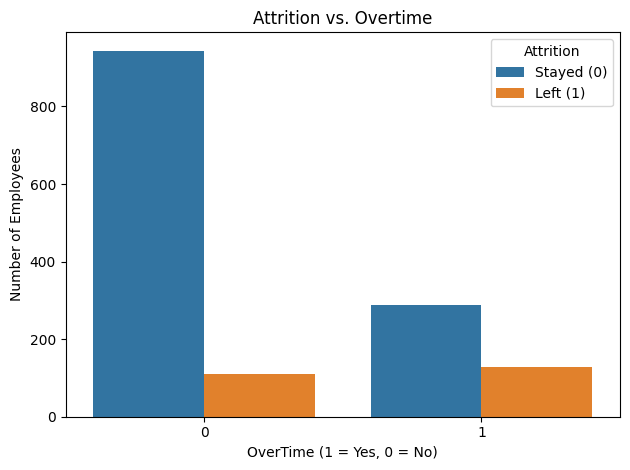

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x='OverTime', hue='Attrition', data=df)
plt.title('Attrition vs. Overtime')
plt.xlabel('OverTime (1 = Yes, 0 = No)')
plt.ylabel('Number of Employees')
plt.legend(title='Attrition', labels=['Stayed (0)', 'Left (1)'])
plt.tight_layout()
plt.show()

Overtime appears to be a strong predictor of attrition. Employees who worked overtime left the company at a significantly higher rate than those who didn’t

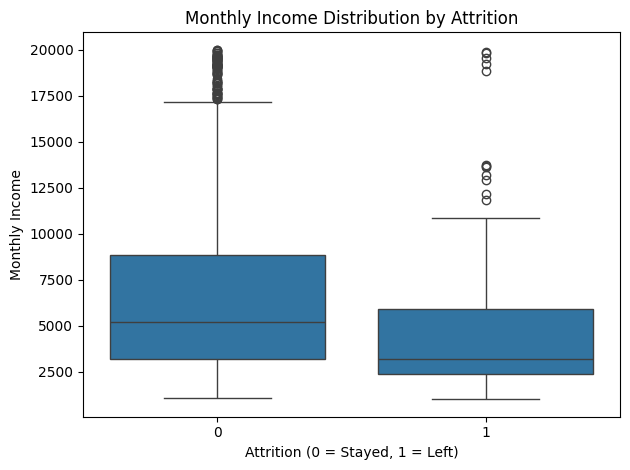

In [11]:
sns.boxplot(x='Attrition', y='MonthlyIncome', data=df)
plt.title('Monthly Income Distribution by Attrition')
plt.xlabel('Attrition (0 = Stayed, 1 = Left)')
plt.ylabel('Monthly Income')
plt.tight_layout()
plt.show()

Employees who left the company generally earned less than those who stayed. Higher salaries may be linked to improved retention.

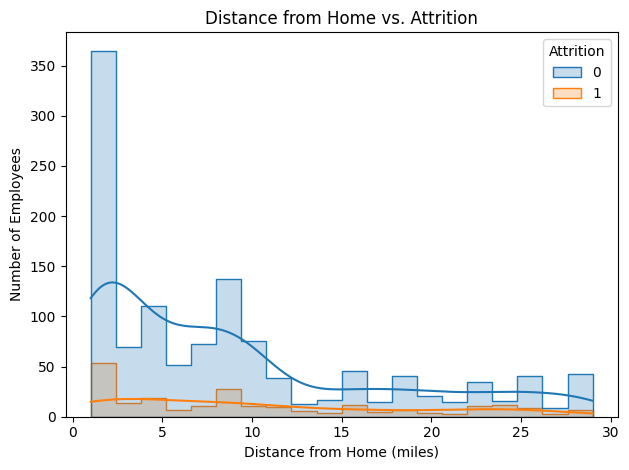

In [12]:
sns.histplot(data=df, x='DistanceFromHome', hue='Attrition', bins=20, kde=True, element='step')
plt.title('Distance from Home vs. Attrition')
plt.xlabel('Distance from Home (miles)')
plt.ylabel('Number of Employees')
plt.tight_layout()
plt.show()

Longer commutes appear to be modestly associated with increased attrition. While most employees live nearby, those with longer distances show higher rates of departure.

## K-Means Clustering
Now we will be using K-Means clustering to determine employees most closely clustered together

In [13]:
features = [
    'Age',
    'DistanceFromHome',
    'MonthlyIncome',
    'TotalWorkingYears',
    'YearsAtCompany',
    'JobSatisfaction',
    'EnvironmentSatisfaction',
    'WorkLifeBalance',
    'OverTime'
]

In [14]:
from sklearn.preprocessing import StandardScaler

X = df[features].copy()
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [15]:
from sklearn.cluster import KMeans


kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = KMeans(n_clusters=3, random_state=42).fit_predict(X_scaled)

In [16]:
cluster_summary = df.groupby('Cluster')['Attrition'].agg(['count', 'sum', 'mean']).rename(columns={
    'count': 'Total Employees',
    'sum': 'Attrition Count',
    'mean': 'Attrition Rate'
})

cluster_summary

,Total Employees,Attrition Count,Attrition Rate
Cluster,,,
0,467,103,0.220557
1,258,20,0.077519
2,745,114,0.153020


K-Means clustering reveals a high-risk employee group (Cluster 0) with an attrition rate nearly 3x higher than that of the lowest-risk group (Cluster 1). This suggests underlying combinations of factors driving resignation that are detectable through clustering.

In [17]:
feature_means = df.groupby('Cluster')[features].mean().round(2)
feature_means

,Age,DistanceFromHome,MonthlyIncome,TotalWorkingYears,YearsAtCompany,JobSatisfaction,EnvironmentSatisfaction,WorkLifeBalance,OverTime
Cluster,,,,,,,,,
0,34.56,9.05,4780.98,8.54,5.34,1.48,2.75,2.78,0.27
1,47.62,8.91,14501.95,24.52,14.41,2.70,2.74,2.74,0.29
2,34.70,9.38,4812.20,8.41,5.49,3.52,2.70,2.76,0.29


1. **Cluster 0:** Younger, lower-paid, and least satisfied group — these employees feel undervalued and are most likely to leave. 
2. **Cluster 1:** Veteran employees with high pay and tenure — low risk of departure, possibly more invested.
3. **Cluster 2:** Same pay and age as Cluster 0, but much more satisfied — job experience is similar, but their perception of the workplace is more positive.

Clustering reveals that dissatisfaction—not just pay or tenure—is a major driver of attrition. Cluster 0 and 2 have similar demographics and income, yet attrition is higher in Cluster 0 where satisfaction is lowest

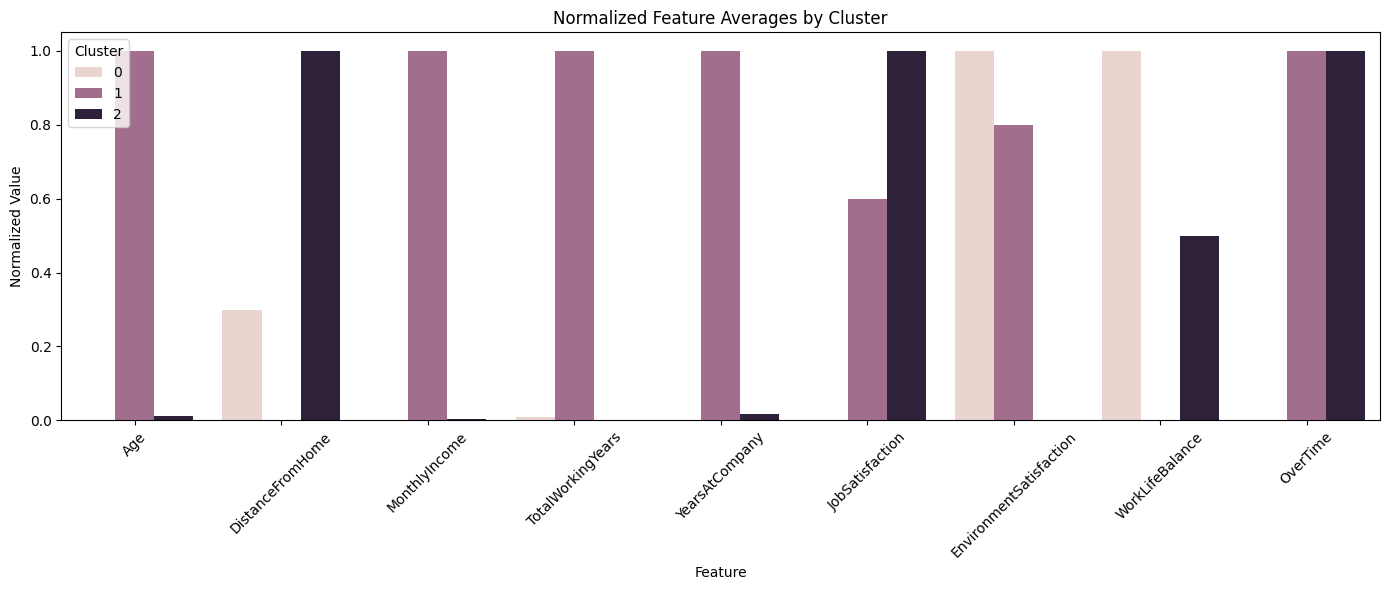

In [18]:
# Melt normalized values for barplot
# Normalize values to 0‑1 range for comparison
normalized = (feature_means - feature_means.min()) / (feature_means.max() - feature_means.min())

normalized_reset = normalized.reset_index().melt(id_vars='Cluster', var_name='Feature', value_name='Normalized Value')

plt.figure(figsize=(14,6))
sns.barplot(data=normalized_reset, x='Feature', y='Normalized Value', hue='Cluster')
plt.title('Normalized Feature Averages by Cluster')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

- **Cluster 1** is the ideal profile: senior, well-paid, stable, moderately satisfied. Unsurprisingly, this group has the lowest attrition.
- **Cluster 0** employees are young, underpaid, short-tenured, and deeply unsatisfied — despite reporting decent environment and work-life balance. This group is most likely to quit.
- **Cluster 2** resembles Cluster 0 demographically and economically, but high satisfaction and motivation appear to help mitigate attrition.

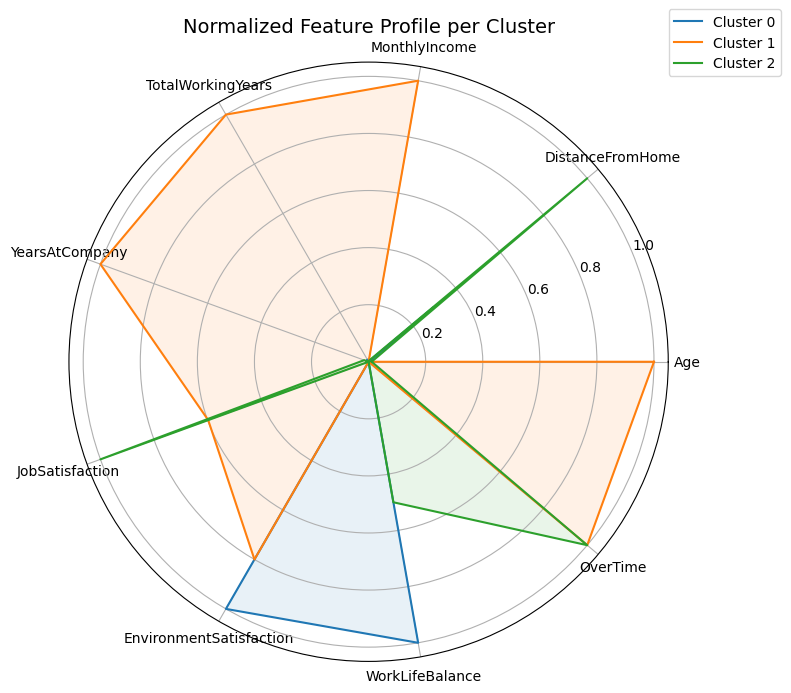

In [19]:
import numpy as np
# Normalize values to 0-1 range for comparison
normalized = (feature_means - feature_means.min()) / (feature_means.max() - feature_means.min())

# Setup
labels = normalized.columns
num_vars = len(labels)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # close the loop

fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

# Plot each cluster
for i, row in normalized.iterrows():
    values = row.tolist()
    values += values[:1]  # close the loop
    ax.plot(angles, values, label=f'Cluster {i}')
    ax.fill(angles, values, alpha=0.1)

ax.set_title('Normalized Feature Profile per Cluster', size=14)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(labels, fontsize=10)
ax.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.tight_layout()
plt.show()

Attrition is most closely associated with low job satisfaction, low compensation, and low tenure. Even when environment and work-life balance are good (as in Cluster 0), lack of growth or recognition drives people out. On the other hand, employees who feel satisfied and see a future (Cluster 2), or those who are well-established (Cluster 1), are more likely to stay.

## 4. PCA Visualization

In [20]:
# Target
y = df['Attrition']

# Drop target and cluster label if present
X = df.drop(['Attrition', 'Cluster'], axis=1, errors='ignore')  # 'Cluster' may not exist

In [21]:
X.dtypes.value_counts()

int64     24
object     6
Name: count, dtype: int64

In [22]:
X_encoded = pd.get_dummies(X, drop_first=True)  # drop_first avoids multicollinearity
X_encoded.shape

(1470, 44)

In [23]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)

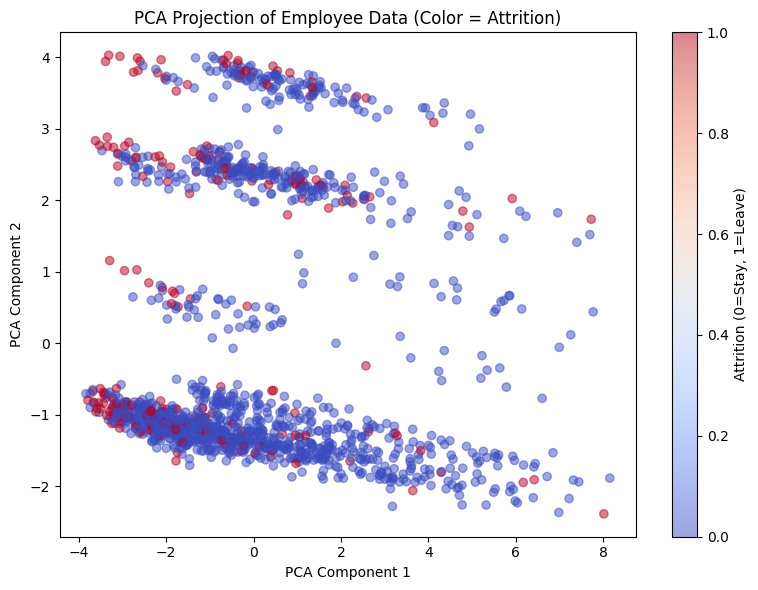

In [24]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Fit PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='coolwarm', alpha=0.5)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Projection of Employee Data (Color = Attrition)')
plt.colorbar(label='Attrition (0=Stay, 1=Leave)')
plt.tight_layout()
plt.show()


There's some clustering and separation between attrition classes, but not a perfect boundary.

- **Red dots** (Attrition = 1) are somewhat concentrated in certain horizontal bands (e.g., top-left and mid-right), which suggests that PCA has picked up meaningful variance related to attrition.
- However, there's still a lot of overlap — meaning that attrition prediction won't be perfect, but likely learnable with the full feature set.

PCA is helpful for visual exploration, but we'll likely get better classification results using the full feature set (X_scaled) rather than just the 2 PCA components.

## 5. Logistic Regression Model

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

# Fit model
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train, y_train)

# Predict
y_pred = lr.predict(X_test)

# Evaluate
print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

[[359  11]
 [ 42  29]]
              precision    recall  f1-score   support

           0       0.90      0.97      0.93       370
           1       0.72      0.41      0.52        71

    accuracy                           0.88       441
   macro avg       0.81      0.69      0.73       441
weighted avg       0.87      0.88      0.87       441



### Logistic Regression Evaluation Summary

- The model correctly predicted **359 employees to stay** and **29 to leave**.
- It **missed 42 actual leavers** (*false negatives*) and produced **11 false positives** (*predicted leave, but actually stayed*).

---

### Conclusion:

The model is affected by **class imbalance**, which reduces **recall** for predicting leavers. It takes a **conservative approach**, generally predicting that employees will stay — resulting in high overall accuracy but limited sensitivity to attrition.

- The **precision for leavers is 72%**, meaning that when the model does flag someone as a potential flight risk, it’s often correct.
- This makes the model **practically useful** as an early warning system — especially when used to **support**, not replace, HR decision-making.
- However, the **false negatives (missed leavers)** are a key limitation. Any actions based on this model should factor in the **risk of underestimating actual attrition**.


## 6. Model Evaluation & Interpretation

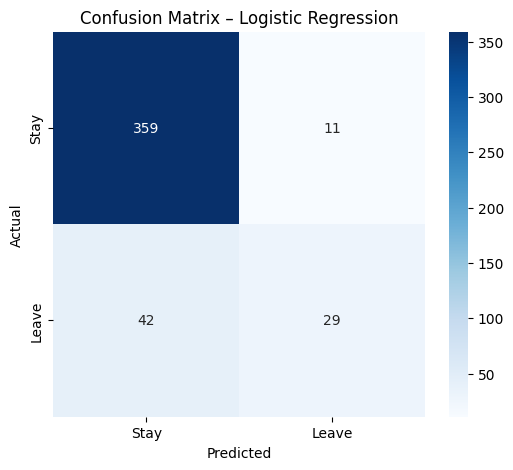

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Recalculate predictions if needed
y_pred = lr.predict(X_test)

# Create confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Stay', 'Leave'], yticklabels=['Stay', 'Leave'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix – Logistic Regression')
plt.show()

## Model Performance Summary

- The model is very reliable at detecting who will stay (359/370 accuracy).
- It's moderately effective at identifying leavers (29/71 recall = 41%).
- Because attrition is rare (~16%), this performance is expected for a basic logistic model — but there's room to improve by addressing false negatives.

/var/folders/nm/1w1lcjr92ybg8f27lrzxm07w0000gn/T/ipykernel_17603/2982131872.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_features, x='Coefficient', y='Feature', palette='coolwarm')


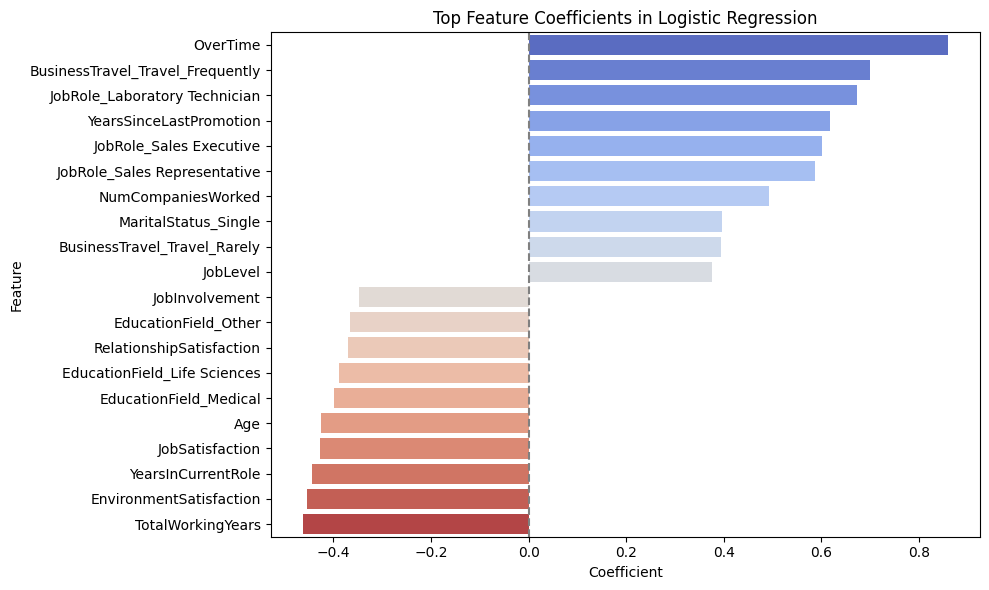

In [27]:
import pandas as pd
import numpy as np

# Get feature importance
coeffs = lr.coef_[0]
feature_names = X_encoded.columns
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coeffs
}).sort_values(by='Coefficient', ascending=False)

# Plot
top_n = 10  # Top positive and negative
top_features = pd.concat([importance_df.head(top_n), importance_df.tail(top_n)])

plt.figure(figsize=(10,6))
sns.barplot(data=top_features, x='Coefficient', y='Feature', palette='coolwarm')
plt.axvline(0, color='gray', linestyle='--')
plt.title('Top Feature Coefficients in Logistic Regression')
plt.tight_layout()
plt.show()

## Logistic Regression Results Summary

### Confusion Matrix
- **359** employees correctly predicted to stay
- **29** correctly predicted to leave
- **42** actual leavers missed (false negatives)
- **11** false positives (predicted leave, but they stayed)

**Interpretation:**  
The model is conservative — it predicts "stay" most of the time, which leads to high overall accuracy (88%), but recall for leavers is lower (41%). Precision for predicting leavers is solid (72%), making the model useful for identifying potential flight risks.

---

### Top Features Driving Attrition

**Most likely to leave** (positive influence):
- `OverTime`
- `BusinessTravel_Travel_Frequently`
- `YearsSinceLastPromotion`
- `JobRole_Laboratory Technician`
- `JobRole_Sales Executive / Representative`

**Most likely to stay** (negative influence):
- `TotalWorkingYears`
- `JobSatisfaction`, `EnvironmentSatisfaction`
- `YearsInCurrentRole`
- `Age`
- `RelationshipSatisfaction`

**Conclusion:**  
Employees are more likely to leave when they work overtime, travel frequently, or haven't been promoted in a while. Satisfaction, stability, and experience reduce attrition risk.

## 🚀 Next Model Improvements (Not Implemented Here)

| Idea | Expected Gain |
|------|--------------|
| **SMOTE / class‑weighted loss** | Lift recall on leavers without hurting precision too much |
| **Tree‑based model (RF / XGBoost)** | Capture non‑linear interactions; usually ↑ AUC |
| **Threshold tuning** | Business may prefer higher recall even at cost of precision |
| **SHAP values** | HR‑friendly explanations for individual risk scores |